# A simple feed forward model
- Authors: Doris Fu, Eshika Saxena
- Objective: Use simulated RNA-seq profiles to represent the perturbed cell line transcriptome. Pass the simulated profiles to regularized neural network model to perform independent prediction of cell viability score for each gene perturbation.

In [31]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import os 
import shutil

import copy

import tensorflow as tf
import tensorflow.keras as K

from sklearn.model_selection import train_test_split
import CCLE_utils
import MMRF_utils

## Load train and test sets

In [32]:
lenal_df = pd.read_csv('lenalidomide_crispr_knockout.csv')
bortez_df = pd.read_csv('bortezomib_crispr_knockout.csv')

In [33]:
map_dict = CCLE_utils.get_map_dict('Ensembl_HGNC_map_042421.csv')

In [34]:
X_lenal_cell_data = lenal_df.drop(columns = ['DepMap_ID','Knockout','Response'])
X_lenal_cell_data = CCLE_utils.hgnc_to_ensembl(X_lenal_cell_data, map_dict)

y_lenal_cell_data = lenal_df['Response']

In [35]:
X_bortez_cell_data = bortez_df.drop(columns = ['DepMap_ID','Knockout','Response'])
X_bortez_cell_data = CCLE_utils.hgnc_to_ensembl(X_bortez_cell_data, map_dict)

y_bortez_cell_data = bortez_df['Response']

In [37]:
X_lenal_cell_train, X_lenal_cell_test, y_lenal_cell_train, y_lenal_cell_test = train_test_split(X_lenal_cell_data,y_lenal_cell_data,random_state=42, train_size=0.7)

X_bortez_cell_train, X_bortez_cell_test, y_bortez_cell_train, y_bortez_cell_test = train_test_split(X_bortez_cell_data,y_bortez_cell_data,random_state=42, train_size=0.7)

## Encode input features 

In [55]:
from sklearn.decomposition import PCA

nPCA = 500
pca = PCA(n_components=nPCA)
X_lenal_cell_train_pca = pca.fit_transform(X_lenal_cell_train)
X_lenal_cell_test_pca = pca.transform(X_lenal_cell_test)

print(X_lenal_cell_train_pca.shape, X_lenal_cell_test_pca.shape)

(567, 500) (243, 500)


In [59]:
nPCA = 500
pca = PCA(n_components=nPCA)
X_bortez_cell_train_pca = pca.fit_transform(X_bortez_cell_train)
X_bortez_cell_test_pca = pca.transform(X_bortez_cell_test)

print(X_bortez_cell_train_pca.shape, X_bortez_cell_test_pca.shape)

(2818, 500) (1208, 500)


# Train NN on cell line

In [39]:
def generate_model(N):
    # N : number of input feature

    model = K.Sequential([
        K.layers.Dropout(0.2, input_shape=(N,)),
        K.layers.Dense(1024, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.001)),
        K.layers.Dropout(0.5),
        K.layers.Dense(128, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.001)),
        K.layers.Dropout(0.5),
        K.layers.Dense(32, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.001)),
        K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001))
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [40]:
lenal_model = generate_model(X_lenal_cell_train.shape[1])
history = lenal_model.fit(X_lenal_cell_train, y_lenal_cell_train, epochs=100, validation_data=(X_lenal_cell_test, y_lenal_cell_test))

Epoch 1/100
18/18 [==============================] - 5s 206ms/step - loss: 2094.3011 - root_mean_squared_error: 44.3847 - val_loss: 10.0798 - val_root_mean_squared_error: 2.8023
Epoch 2/100
18/18 [==============================] - 3s 184ms/step - loss: 521.7892 - root_mean_squared_error: 22.7588 - val_loss: 50.7619 - val_root_mean_squared_error: 6.9606
Epoch 3/100
18/18 [==============================] - 3s 185ms/step - loss: 191.9994 - root_mean_squared_error: 13.7550 - val_loss: 5.7821 - val_root_mean_squared_error: 1.8655
Epoch 4/100
18/18 [==============================] - 4s 187ms/step - loss: 74.9095 - root_mean_squared_error: 8.5049 - val_loss: 5.5789 - val_root_mean_squared_error: 1.8172
Epoch 5/100
18/18 [==============================] - 3s 173ms/step - loss: 47.8322 - root_mean_squared_error: 6.7450 - val_loss: 3.5906 - val_root_mean_squared_error: 1.1572
Epoch 6/100
18/18 [==============================] - 3s 166ms/step - loss: 29.2037 - root_mean_squared_error: 5.1844 - va

18/18 [==============================] - 3s 158ms/step - loss: 2.0709 - root_mean_squared_error: 0.5878 - val_loss: 1.7740 - val_root_mean_squared_error: 0.2410
Epoch 49/100
18/18 [==============================] - 3s 191ms/step - loss: 1.8899 - root_mean_squared_error: 0.4188 - val_loss: 1.7658 - val_root_mean_squared_error: 0.2410
Epoch 50/100
18/18 [==============================] - 3s 195ms/step - loss: 1.8973 - root_mean_squared_error: 0.4347 - val_loss: 1.7576 - val_root_mean_squared_error: 0.2410
Epoch 51/100
18/18 [==============================] - 4s 197ms/step - loss: 1.8293 - root_mean_squared_error: 0.3609 - val_loss: 1.7495 - val_root_mean_squared_error: 0.2409
Epoch 52/100
18/18 [==============================] - 3s 185ms/step - loss: 1.8850 - root_mean_squared_error: 0.4383 - val_loss: 1.7415 - val_root_mean_squared_error: 0.2409
Epoch 53/100
18/18 [==============================] - 4s 206ms/step - loss: 1.8363 - root_mean_squared_error: 0.3920 - val_loss: 1.7336 - val_r

In [49]:
bortez_model = generate_model(X_bortez_cell_train.shape[1])
bortez_history = bortez_model.fit(X_bortez_cell_train, y_bortez_cell_train, epochs=100, validation_data=(X_bortez_cell_test, y_bortez_cell_test))

Epoch 1/100
89/89 [==============================] - 19s 200ms/step - loss: 1303.4295 - root_mean_squared_error: 33.9707 - val_loss: 4.8333 - val_root_mean_squared_error: 1.5907
Epoch 2/100
89/89 [==============================] - 15s 168ms/step - loss: 11.7461 - root_mean_squared_error: 3.0650 - val_loss: 3.2370 - val_root_mean_squared_error: 1.0166
Epoch 3/100
89/89 [==============================] - 14s 162ms/step - loss: 5.8510 - root_mean_squared_error: 1.9121 - val_loss: 2.9615 - val_root_mean_squared_error: 0.9147
Epoch 4/100
89/89 [==============================] - 17s 195ms/step - loss: 4.5567 - root_mean_squared_error: 1.5606 - val_loss: 3.9218 - val_root_mean_squared_error: 1.3656
Epoch 5/100
89/89 [==============================] - 16s 178ms/step - loss: 3.6005 - root_mean_squared_error: 1.2476 - val_loss: 3.6628 - val_root_mean_squared_error: 1.2909
Epoch 6/100
89/89 [==============================] - 15s 167ms/step - loss: 3.9651 - root_mean_squared_error: 1.4047 - val_lo

Epoch 48/100
89/89 [==============================] - 13s 151ms/step - loss: 1.4937 - root_mean_squared_error: 0.7710 - val_loss: 1.5116 - val_root_mean_squared_error: 0.7895
Epoch 49/100
89/89 [==============================] - 13s 149ms/step - loss: 1.4978 - root_mean_squared_error: 0.7827 - val_loss: 1.4980 - val_root_mean_squared_error: 0.7896
Epoch 50/100
89/89 [==============================] - 14s 152ms/step - loss: 1.4753 - root_mean_squared_error: 0.7773 - val_loss: 1.4837 - val_root_mean_squared_error: 0.7895
Epoch 51/100
89/89 [==============================] - 13s 144ms/step - loss: 1.4567 - root_mean_squared_error: 0.7745 - val_loss: 1.4694 - val_root_mean_squared_error: 0.7895
Epoch 52/100
89/89 [==============================] - 13s 147ms/step - loss: 1.4473 - root_mean_squared_error: 0.7776 - val_loss: 1.4554 - val_root_mean_squared_error: 0.7895
Epoch 53/100
89/89 [==============================] - 13s 144ms/step - loss: 1.4560 - root_mean_squared_error: 0.7918 - val_l

Epoch 95/100
89/89 [==============================] - 13s 145ms/step - loss: 0.9753 - root_mean_squared_error: 0.7890 - val_loss: 0.9690 - val_root_mean_squared_error: 0.7895
Epoch 96/100
89/89 [==============================] - 13s 141ms/step - loss: 0.9443 - root_mean_squared_error: 0.7756 - val_loss: 0.9578 - val_root_mean_squared_error: 0.7896
Epoch 97/100
89/89 [==============================] - 13s 141ms/step - loss: 0.9353 - root_mean_squared_error: 0.7757 - val_loss: 0.9533 - val_root_mean_squared_error: 0.7895
Epoch 98/100
89/89 [==============================] - 13s 141ms/step - loss: 1.0492 - root_mean_squared_error: 0.8379 - val_loss: 1.0194 - val_root_mean_squared_error: 0.7896
Epoch 99/100
89/89 [==============================] - 14s 155ms/step - loss: 1.0485 - root_mean_squared_error: 0.8028 - val_loss: 1.0334 - val_root_mean_squared_error: 0.7896
Epoch 100/100
89/89 [==============================] - 13s 146ms/step - loss: 1.0668 - root_mean_squared_error: 0.8051 - val_

In [57]:
pca_model = generate_model(X_lenal_cell_train_pca.shape[1])
pca_history = pca_model.fit(X_lenal_cell_train_pca, y_lenal_cell_train, epochs=100, validation_data=(X_lenal_cell_test_pca, y_lenal_cell_test))

Epoch 1/100
18/18 [==============================] - 1s 15ms/step - loss: 50.1239 - root_mean_squared_error: 6.8349 - val_loss: 1.5661 - val_root_mean_squared_error: 0.8459
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 6.6105 - root_mean_squared_error: 2.3974 - val_loss: 1.1635 - val_root_mean_squared_error: 0.5963
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 3.3210 - root_mean_squared_error: 1.5862 - val_loss: 1.0724 - val_root_mean_squared_error: 0.5282
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 2.4188 - root_mean_squared_error: 1.2733 - val_loss: 0.9384 - val_root_mean_squared_error: 0.3860
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 1.8358 - root_mean_squared_error: 1.0215 - val_loss: 0.8827 - val_root_mean_squared_error: 0.3074
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 1.8138 - root_mean_squared_error: 1.0106 - val_loss: 0.8720 - val_roo

Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 0.8167 - root_mean_squared_error: 0.2648 - val_loss: 0.8021 - val_root_mean_squared_error: 0.2380
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 0.8102 - root_mean_squared_error: 0.2551 - val_loss: 0.8003 - val_root_mean_squared_error: 0.2372
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 0.8327 - root_mean_squared_error: 0.2963 - val_loss: 0.7982 - val_root_mean_squared_error: 0.2358
Epoch 52/100
18/18 [==============================] - 0s 7ms/step - loss: 0.8192 - root_mean_squared_error: 0.2774 - val_loss: 0.7972 - val_root_mean_squared_error: 0.2366
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 0.8101 - root_mean_squared_error: 0.2629 - val_loss: 0.7957 - val_root_mean_squared_error: 0.2366
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 0.8093 - root_mean_squared_error: 0.2641 - val_loss: 0.7941 - val_

In [60]:
pca_model2 = generate_model(X_bortez_cell_train_pca.shape[1])
pca_history2 = pca_model2.fit(X_bortez_cell_train_pca, y_bortez_cell_train, epochs=100, validation_data=(X_bortez_cell_test_pca, y_bortez_cell_test))

Epoch 1/100
89/89 [==============================] - 1s 7ms/step - loss: 22.5449 - root_mean_squared_error: 4.4673 - val_loss: 1.5887 - val_root_mean_squared_error: 0.8887
Epoch 2/100
89/89 [==============================] - 0s 5ms/step - loss: 2.6694 - root_mean_squared_error: 1.3663 - val_loss: 1.8120 - val_root_mean_squared_error: 1.0073
Epoch 3/100
89/89 [==============================] - 1s 6ms/step - loss: 2.0052 - root_mean_squared_error: 1.0990 - val_loss: 1.6751 - val_root_mean_squared_error: 0.9379
Epoch 4/100
89/89 [==============================] - 1s 6ms/step - loss: 1.7731 - root_mean_squared_error: 0.9887 - val_loss: 1.6670 - val_root_mean_squared_error: 0.9350
Epoch 5/100
89/89 [==============================] - 1s 7ms/step - loss: 1.5729 - root_mean_squared_error: 0.8826 - val_loss: 1.7478 - val_root_mean_squared_error: 0.9788
Epoch 6/100
89/89 [==============================] - 0s 5ms/step - loss: 1.5354 - root_mean_squared_error: 0.8638 - val_loss: 1.6905 - val_root_

Epoch 49/100
89/89 [==============================] - 0s 5ms/step - loss: 0.7776 - root_mean_squared_error: 0.5529 - val_loss: 1.1545 - val_root_mean_squared_error: 0.8312
Epoch 50/100
89/89 [==============================] - 0s 5ms/step - loss: 0.7564 - root_mean_squared_error: 0.5433 - val_loss: 0.9751 - val_root_mean_squared_error: 0.7226
Epoch 51/100
89/89 [==============================] - 0s 5ms/step - loss: 0.7474 - root_mean_squared_error: 0.5455 - val_loss: 1.1011 - val_root_mean_squared_error: 0.8122
Epoch 52/100
89/89 [==============================] - 0s 5ms/step - loss: 0.7160 - root_mean_squared_error: 0.5263 - val_loss: 0.9770 - val_root_mean_squared_error: 0.7390
Epoch 53/100
89/89 [==============================] - 0s 5ms/step - loss: 0.7415 - root_mean_squared_error: 0.5593 - val_loss: 0.9854 - val_root_mean_squared_error: 0.7516
Epoch 54/100
89/89 [==============================] - 0s 5ms/step - loss: 0.6962 - root_mean_squared_error: 0.5271 - val_loss: 0.9976 - val_

# Eval performance on cell line test set

In [43]:
def plot_loss(perf_dict):
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    loss = perf_dict['loss']
    val_loss = perf_dict['val_loss']
    ax1.plot(loss)
    ax2.plot(val_loss)
    ax1.set_xlabel('epochs')
    ax2.set_xlabel('epochs')

    ax1.set_ylabel('loss')
    ax2.set_ylabel('val_loss')
    plt.show()

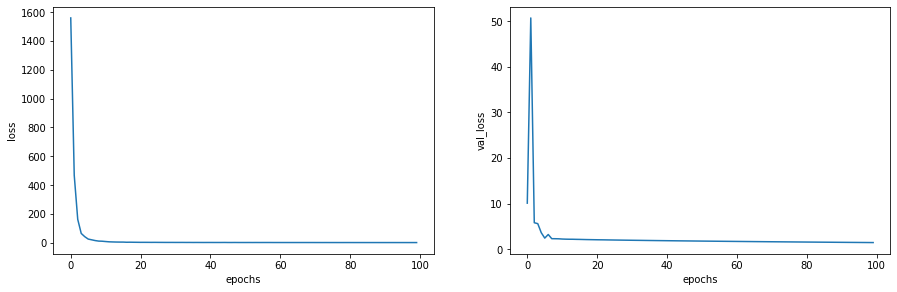

In [44]:
plot_loss(history.history)

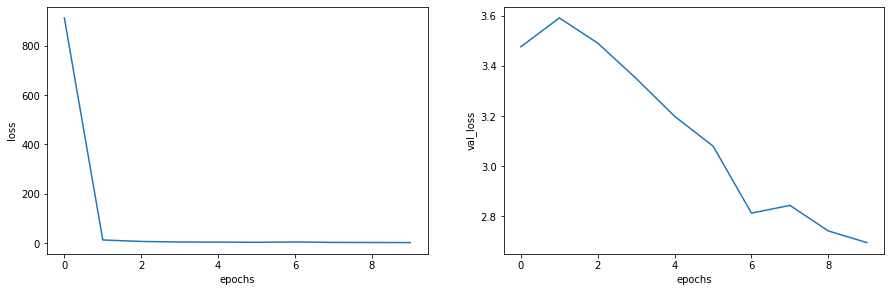

In [45]:
plot_loss(bortez_history.history)

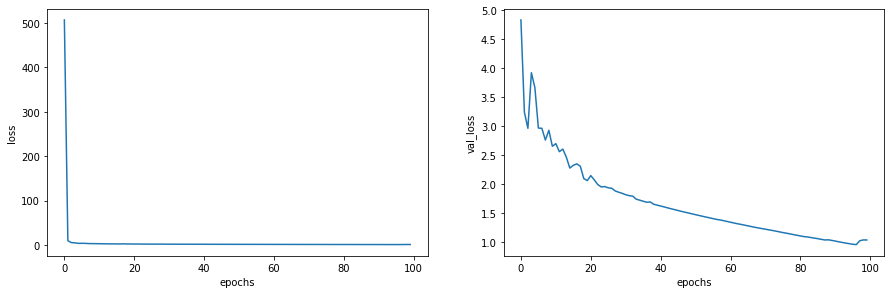

In [50]:
plot_loss(bortez_history.history)

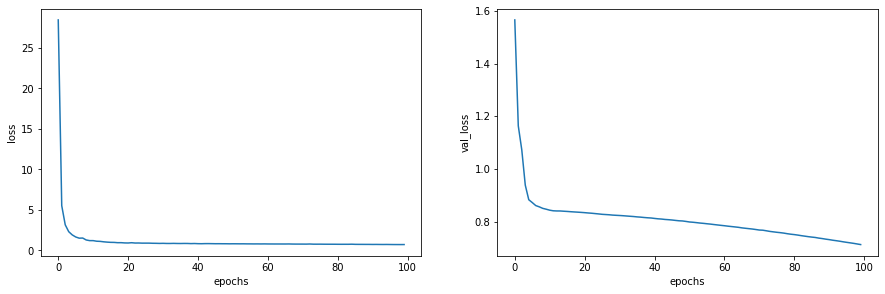

In [61]:
plot_loss(pca_history.history)
ax1.set_title('')

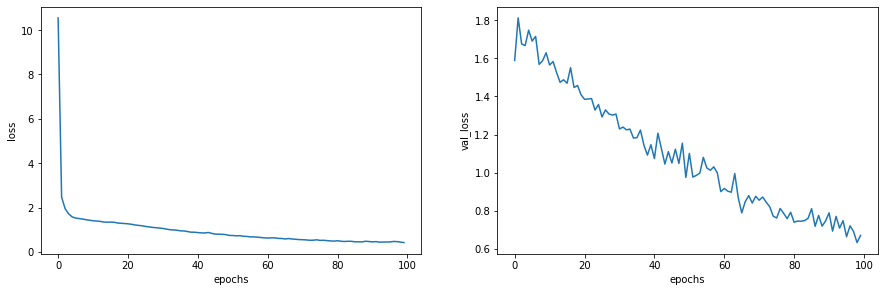

In [62]:
plot_loss(pca_history2.history)

## Plot y_true against y_predicted

Text(0.5, 1.0, 'CRISPR Knockout Experiments - Lenalidomide')

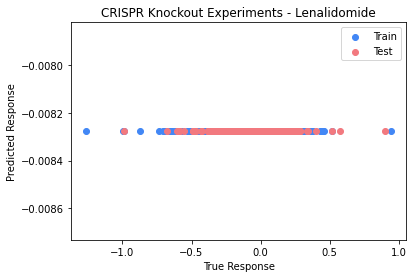

In [47]:
fig, ax = plt.subplots(1,1)

ax.scatter(y_lenal_cell_train,lenal_model.predict(X_lenal_cell_train), label='Train', color='#4287f5')
ax.scatter(y_lenal_cell_test,lenal_model.predict(X_lenal_cell_test), label='Test', color='#f2797f')

ax.set_xlabel('True Response')
ax.set_ylabel('Predicted Response')
ax.legend()
ax.set_title('CRISPR Knockout Experiments - Lenalidomide')

Text(0.5, 1.0, 'CRISPR Knockout Experiments - Lenalidomide with PCA')

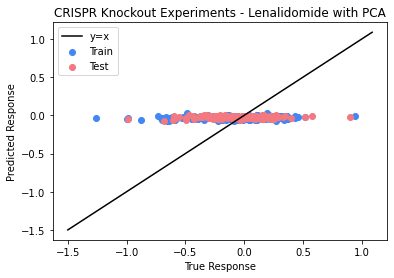

In [66]:
x = np.arange(-1.5,1.1,0.01)
fig, ax = plt.subplots(1,1)
ax.plot(x, x, label='y=x', color='black')

ax.scatter(y_lenal_cell_train,pca_model.predict(X_lenal_cell_train_pca), label='Train', color='#4287f5')
ax.scatter(y_lenal_cell_test,pca_model.predict(X_lenal_cell_test_pca), label='Test', color='#f2797f')

ax.set_xlabel('True Response')
ax.set_ylabel('Predicted Response')
ax.legend()
ax.set_title('CRISPR Knockout Experiments - Lenalidomide with PCA')

Text(0.5, 1.0, 'CRISPR Knockout Experiments - Bortezomib with PCA')

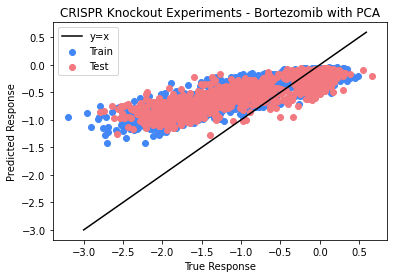

In [65]:
x = np.arange(-3,0.6,0.01)
fig, ax = plt.subplots(1,1)
ax.plot(x, x, label='y=x', color='black')

ax.scatter(y_bortez_cell_train,pca_model2.predict(X_bortez_cell_train_pca), label='Train', color='#4287f5')
ax.scatter(y_bortez_cell_test,pca_model2.predict(X_bortez_cell_test_pca), label='Test', color='#f2797f')

ax.set_xlabel('True Response')
ax.set_ylabel('Predicted Response')
ax.legend()
ax.set_title('CRISPR Knockout Experiments - Bortezomib with PCA')

Text(0.5, 1.0, 'CRISPR Knockout Experiments - Bortezomib')

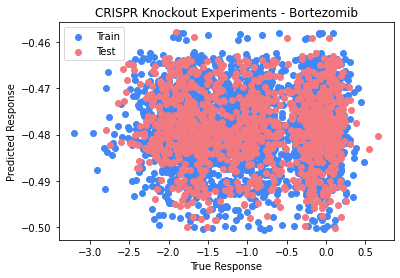

In [48]:
fig, ax = plt.subplots(1,1)

ax.scatter(y_bortez_cell_train,bortez_model.predict(X_bortez_cell_train), label='Train', color='#4287f5')
ax.scatter(y_bortez_cell_test,bortez_model.predict(X_bortez_cell_test), label='Test', color='#f2797f')

ax.set_xlabel('True Response')
ax.set_ylabel('Predicted Response')
ax.legend()
ax.set_title('CRISPR Knockout Experiments - Bortezomib')

Text(0.5, 1.0, 'CRISPR Knockout Experiments - Bortezomib')

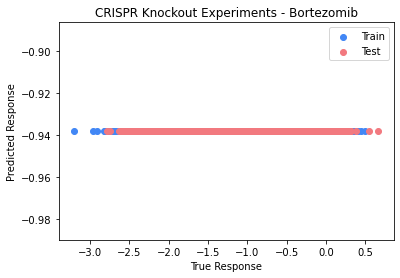

In [51]:
fig, ax = plt.subplots(1,1)

ax.scatter(y_bortez_cell_train,bortez_model.predict(X_bortez_cell_train), label='Train', color='#4287f5')
ax.scatter(y_bortez_cell_test,bortez_model.predict(X_bortez_cell_test), label='Test', color='#f2797f')

ax.set_xlabel('True Response')
ax.set_ylabel('Predicted Response')
ax.legend()
ax.set_title('CRISPR Knockout Experiments - Bortezomib')